In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [4]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """

    def policy_fn(observation):
        q = Q[observation]
        pi = np.zeros(len(q))
        pi[np.argmax(q)] = 1.0
        return pi
        # Implement this!
    return policy_fn

In [5]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Lambda discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    # Implement this!
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    for episode in range(1, num_episodes+1):
        if episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(episode, num_episodes), end="")
            sys.stdout.flush()
            
        observation = env.reset()
        s = observation
        g = 0
        w = 1
        i = 0
        for t in range(100):
            mu = behavior_policy(observation)
            action = np.random.choice(range(env.nA), p=mu)
            if t == 0:
                a = action
            pi = target_policy(observation)
            if action != np.argmax(pi):
                # 如果出现了behavior policy和action policy的差异
                s = observation
                a = action
                g = 0
                w = 1
                i = t
            observation, reward, done, _ = env.step(action)
            w *= 1.0 / mu[action]
            g += discount_factor ** (t-i) * reward
            if done:
                k = s + (a, )
                returns_sum[k] += w*g
                returns_count[k] += w
                break

    for k in returns_sum:
        Q[k[:-1]][k[-1]] = returns_sum[k] / returns_count[k]            
    return Q, target_policy

In [6]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

Episode 500000/500000.

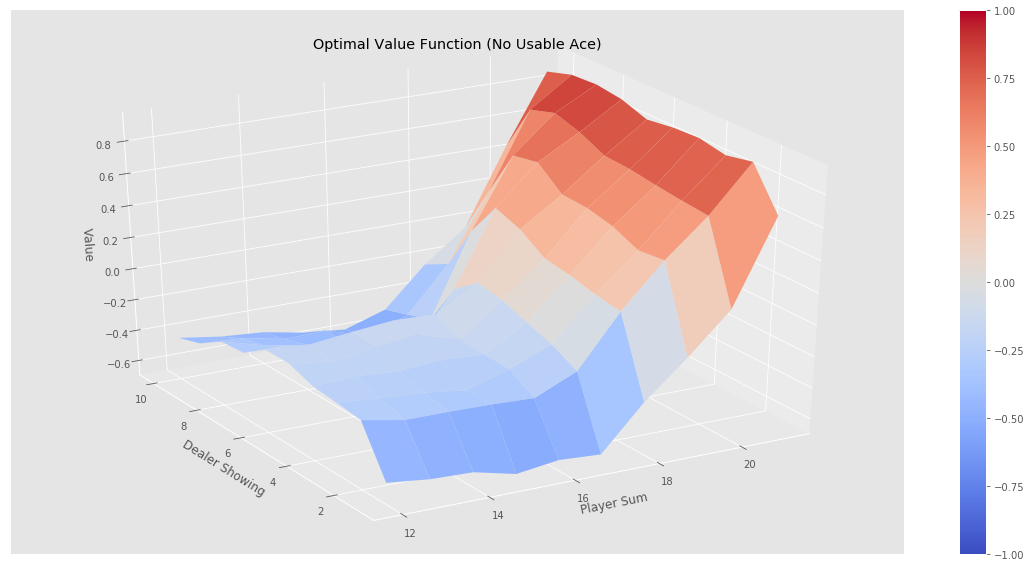

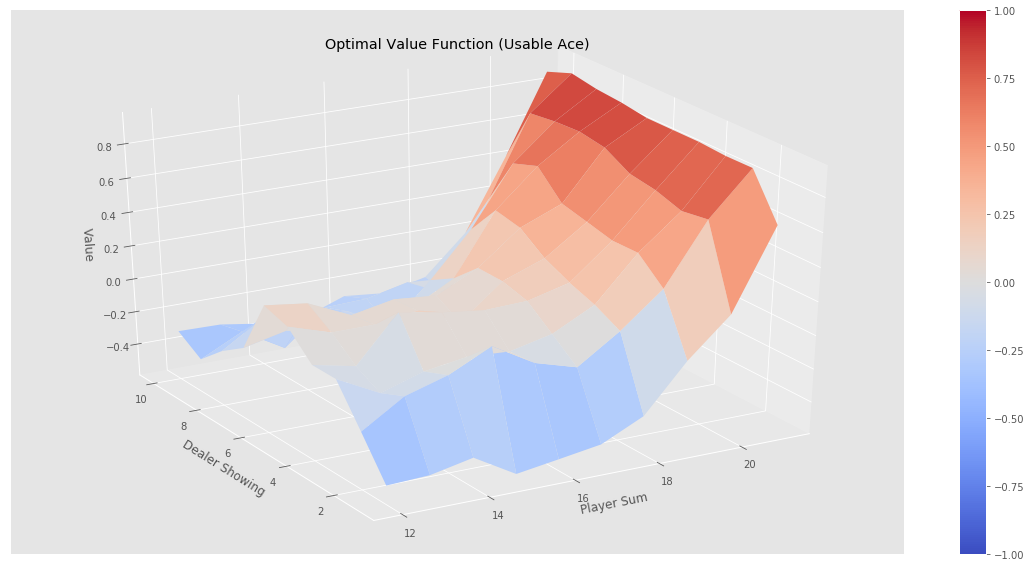

In [7]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")